In [1]:
import scanpy as sc
from scipy.sparse import csc_matrix, csr_matrix, save_npz
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns

In [44]:
folder = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas' 
atac_anno = pd.read_csv('%s/ATAC/cell_metadata.tissue_freq_filtered_brain.txt' % folder, index_col=0)
rna_anno = pd.read_csv('%s/RNA/annotations_facs_brain.csv' % folder, index_col=0)

In [4]:
count1 = pd.read_csv('%s/RNA/FACS/Brain_Myeloid-counts.csv' % folder, index_col=0)
count2 = pd.read_csv('%s/RNA/FACS/Brain_Non-Myeloid-counts.csv' % folder, index_col=0)

In [45]:
adata_rna = sc.AnnData(pd.concat([count1.transpose(), count2.transpose()]))
adata_rna = adata_rna[rna_anno.cell].copy()
rna_anno.set_index('cell', inplace=True)
adata_rna.obs = rna_anno

In [49]:
adata_rna

AnnData object with n_obs × n_vars = 7856 × 23433
    obs: 'Neurog3>0_raw', 'Neurog3>0_scaled', 'cell_ontology_class', 'cell_ontology_id', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'plate.barcode', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids', 'subsetD', 'subsetD_cluster.ids', 'subsetE', 'subsetE_cluster.ids', 'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'annotation'

In [ ]:
count = mmread('%s/ATAC/activity_scores.quantitative.mtx.gz' % folder)

In [34]:
adata_ga = sc.AnnData(count.transpose())
del count
adata_ga.obs_names = pd.read_table('%s/ATAC/activity_scores.quantitative.cells.txt' % folder, header = None)[0].tolist()
adata_ga.var_names = pd.read_table('%s/ATAC/activity_scores.quantitative.genes.txt' % folder, header = None)[0].tolist()
adata_ga = adata_ga[atac_anno.cell].copy()
atac_anno.set_index('cell', inplace=True)
adata_ga.obs = atac_anno

In [50]:
adata_ga

AnnData object with n_obs × n_vars = 16874 × 20783
    obs: 'tissue', 'tissue.replicate', 'cluster', 'subset_cluster', 'tsne_1', 'tsne_2', 'subset_tsne1', 'subset_tsne2', 'id', 'cell_label', 'annotation'

In [51]:
def simMatrix(adata, normalize=True, log=True, hvgs=2000, npcs=30, cell_type='annotation'):
    if normalize:
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if log:
        sc.pp.log1p(adata)
    if hvgs:
        sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_pcs=npcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[cell_type], legend_loc='on data')
    sc.tl.paga(adata, groups=cell_type)
    sc.pl.paga(adata, color=[cell_type])
    pos = adata.uns['paga']['pos']
    D = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]):
            D[i,j] = (((pos[i,]-pos[j,])**2).sum())**.5
    D = D+D.transpose()
    ct = adata.obs[cell_type].cat.categories.tolist()
    sim = pd.DataFrame(np.exp(-D), index=ct, columns=ct)
    return sim

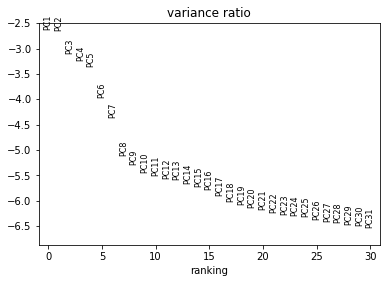

2022-07-14 01:02:28.005951: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ysm-gpfs/apps/software/GCCcore/10.2.0/lib64:/ysm-gpfs/apps/software/GCCcore/10.2.0/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64/R/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64:/ysm-gpfs/apps/software/nodejs/12.19.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GLPK/4.65-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/ImageMagick/7.0.10-35-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/LittleCMS/2.11-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/JasPer/2.0.26-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Ghostscript/9.53.3-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Armadillo/10.2.1-foss-2020b/lib64:/ysm-gpfs/apps/software/arpack-ng/3.8.0-foss-2020b/lib:/ysm-gpfs/apps/software/Boost/1.74.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GSL/2.6-GCCcor

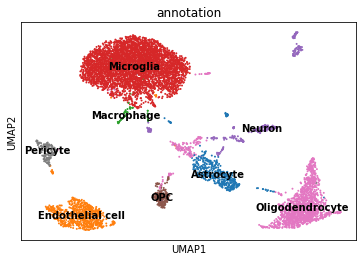

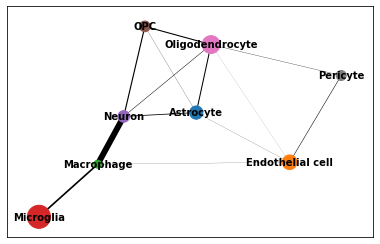

In [52]:
sim_rna = simMatrix(adata_rna)

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:237: RuntimeWarning: invalid value encountered in true_divide
  df['dispersions_norm'] = (


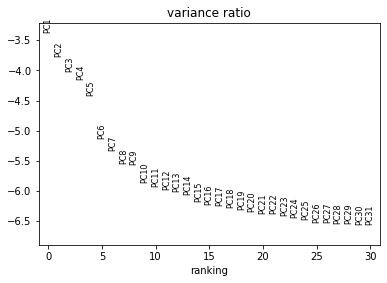

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue.replicate' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a f

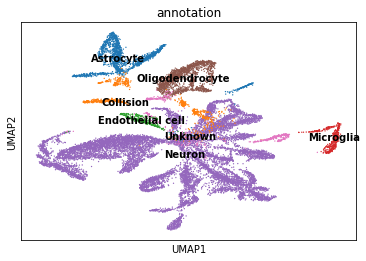

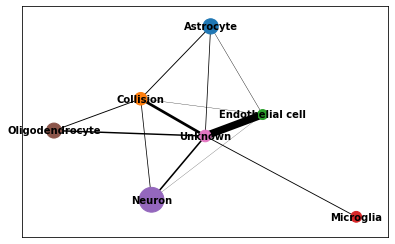

In [53]:
sim_atac = simMatrix(adata_ga)

In [54]:
sim_rna

,Astrocyte,Endothelial cell,Macrophage,Microglia,Neuron,OPC,Oligodendrocyte,Pericyte
Astrocyte,1.000000,0.065976,0.057055,0.008527,0.142045,0.102230,0.226431,0.018803
Endothelial cell,0.065976,1.000000,0.005747,0.001075,0.010438,0.007992,0.038553,0.100908
Macrophage,0.057055,0.005747,1.000000,0.145262,0.293811,0.042221,0.019215,0.001106
Microglia,0.008527,0.001075,0.145262,1.000000,0.044692,0.007330,0.002803,0.000175
Neuron,0.142045,0.010438,0.293811,0.044692,1.000000,0.138349,0.061313,0.002714
OPC,0.102230,0.007992,0.042221,0.007330,0.138349,1.000000,0.162073,0.004613
Oligodendrocyte,0.226431,0.038553,0.019215,0.002803,0.061313,0.162073,1.000000,0.028449
Pericyte,0.018803,0.100908,0.001106,0.000175,0.002714,0.004613,0.028449,1.000000


In [55]:
sim_atac

,Astrocyte,Collision,Endothelial cell,Microglia,Neuron,Oligodendrocyte,Unknown
Astrocyte,1.000000,0.166482,0.140390,0.011800,0.025347,0.045363,0.104054
Collision,0.166482,1.000000,0.171856,0.020037,0.123603,0.247717,0.302684
Endothelial cell,0.140390,0.171856,1.000000,0.082633,0.094214,0.050779,0.395513
Microglia,0.011800,0.020037,0.082633,1.000000,0.053641,0.009620,0.066160
Neuron,0.025347,0.123603,0.094214,0.053641,1.000000,0.136763,0.218505
Oligodendrocyte,0.045363,0.247717,0.050779,0.009620,0.136763,1.000000,0.116553
Unknown,0.104054,0.302684,0.395513,0.066160,0.218505,0.116553,1.000000


<AxesSubplot:>

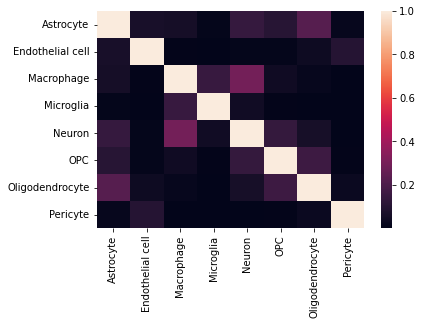

In [56]:
sns.heatmap(sim_rna)

<AxesSubplot:>

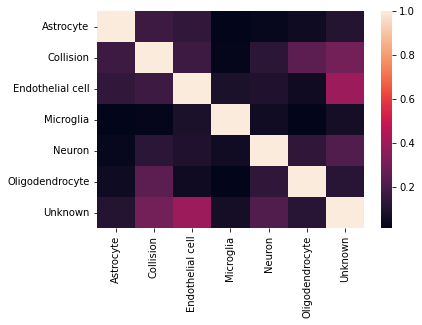

In [57]:
sns.heatmap(sim_atac)

In [94]:
def crossOmicSimMatrix(sim_rna, sim_atac):
    
    ct_rna = sim_rna.index.tolist()
    ct_atac = sim_atac.index.tolist()

    # common cell types
    ct_common = list(set(ct_rna).intersection(ct_atac))

    # rna unique cell types
    ct_rna_only = list(set(ct_rna).difference(ct_atac))

    # atac unique cell types
    ct_atac_only = list(set(ct_atac).difference(ct_rna))
    
    sim = np.zeros((len(ct_atac), len(ct_rna)))
    
    # common to common
    sim[:len(ct_common), :len(ct_common)] = (sim_rna.loc[ct_common, ct_common] + sim_atac.loc[ct_common, ct_common])/2
    
    # atac unique to common
    sim[len(ct_common):, :len(ct_common)] = sim_atac.loc[ct_atac_only, ct_common]
    
    # common to rna unique
    sim[:len(ct_common), len(ct_common):] = sim_rna.loc[ct_common, ct_rna_only]
    
    # atac unique to rna unique
    temp1 = sim_atac.loc[ct_atac_only, ct_common]
    temp1[temp1 < 0.5] = 0
    temp2 = sim_rna.loc[ct_common, ct_rna_only]
    denom = (temp1 != 0).sum(1).values.reshape((-1,1))
    sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom
    
    sim = pd.DataFrame(sim, index = ct_common + ct_atac_only, columns =  ct_common + ct_rna_only).fillna(0)
    
    return sim

In [95]:
sim = crossOmicSimMatrix(sim_rna, sim_atac)

/tmp/ipykernel_24778/3746516461.py:31: RuntimeWarning: invalid value encountered in true_divide
  sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom


In [96]:
sim

,Astrocyte,Oligodendrocyte,Microglia,Endothelial cell,Neuron,OPC,Pericyte,Macrophage
Astrocyte,1.000000,0.135897,0.010163,0.103183,0.083696,0.102230,0.018803,0.057055
Oligodendrocyte,0.135897,1.000000,0.006211,0.044666,0.099038,0.162073,0.028449,0.019215
Microglia,0.010163,0.006211,1.000000,0.041854,0.049167,0.007330,0.000175,0.145262
Endothelial cell,0.103183,0.044666,0.041854,1.000000,0.052326,0.007992,0.100908,0.005747
Neuron,0.083696,0.099038,0.049167,0.052326,1.000000,0.138349,0.002714,0.293811
Unknown,0.104054,0.116553,0.066160,0.395513,0.218505,0.000000,0.000000,0.000000
Collision,0.166482,0.247717,0.020037,0.171856,0.123603,0.000000,0.000000,0.000000


In [97]:
# save
sim.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/data/MouseAtlas/sim_brain.csv')